This document is my notes and code going through the pytorch tutorial of [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

2 Major transfer learning scenarios are:

1. Finetuning the ConvNet: In this we initialize the network with the pretrained network then train like normal.\
2. ConvNet as fixed feature extractor: In this we free the weights of the network except the final fully connected layer. We replace this one with a new one with random weights and only this layer is trained.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

Problem in this tutorial is to classify __ants__ and __bees__. We will have 120 images of each ants and bees. Another 75 validation images for each class. This is considered a small dataset to generalize on.

In [3]:
# Here we will show the data augmentations and normalizations that will improve training
# On validation data we will only do normalizations.
# We need to pull the datasets as well and make the dataloaders based on the pre-made datasets

# Dict that will have the transforms for training data alongside validation.
data_transforms = {
    'train': transforms.Compose([
        # Crop a random portion of image and resize it to a given size. Size is based on ImageNet (224x224).
        transforms.RandomResizedCrop(224),
        # Horizontally flip the given image randomly with a given probability. Default is .5
        transforms.RandomHorizontalFlip(),
        # Makes output a tensor
        transforms.ToTensor(),
        # First array is Mean subtraction so it  subtracts the mean value ([0.485, 0.456, 0.406]) from each
        # color channel (red, green, blue) of the image. This shifts the pixel values closer to zero.
        # Second array is division by standard deviation it divides each color by the values here. 
        # This will scale the pixel values to have a similar range across different channels
        # These numbers were chosen specifically because these are the calculated average mean
        # and standard deviation
        # across the entire ImageNet dataset.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
    'val': transforms.Compose([
        # Resizing image to 256 is standard practice when working with pre-trained models.
        # We don't directly resize to 224x224 as it will affect the aspect ratio of the image.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
# Dict of train data and val data, keyed by 'train' & 'val' respectfully
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

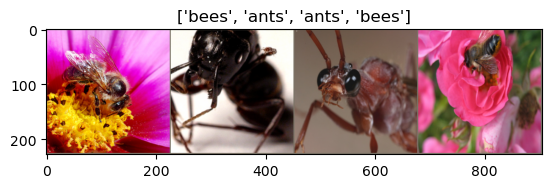

In [4]:
# Visualize the data to make sure datasets and loader are working as expected.
def imshow(inp, title=None):
    """Display image for Tensor."""
    # Move color dimention to the end as plt expects [H, W, C]
    inp = inp.numpy().transpose((1, 2, 0))
    
    # Applying transforms to the images manually
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Fine Tuning ConvNet

In [5]:
# Fine tuning the ConvNet.
# load the pre-trained model and reset final layer

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/blake/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [6]:
# Train model function

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
# Visualizing model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4074 Acc: 0.8238
val Loss: 0.1809 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4209 Acc: 0.8361
val Loss: 0.1904 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4306 Acc: 0.7992
val Loss: 0.2061 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4440 Acc: 0.8320
val Loss: 0.1977 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4097 Acc: 0.8033
val Loss: 0.1845 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4001 Acc: 0.8074
val Loss: 0.2253 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4741 Acc: 0.7828
val Loss: 0.1764 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3522 Acc: 0.8566
val Loss: 0.1880 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3431 Acc: 0.8443
val Loss: 0.1808 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.4164 Acc: 0.8115
val Loss: 0.1828 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3522 Acc: 0.8279
val Loss: 0.1800 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4012 Acc: 0.8197
val Loss: 0.1817 Acc: 0.9477

Ep

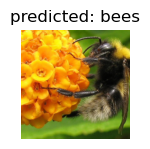

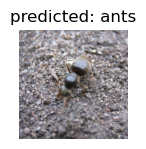

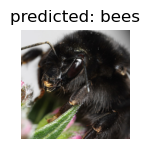

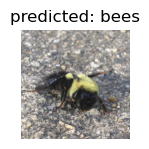

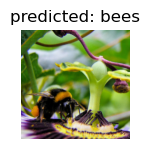

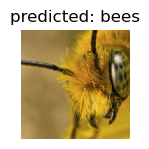

In [11]:
visualize_model(model_ft)

# ConvNet as  fixed feature extractor

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Only major difference here for a fixed feature extractor. Freezing the weights before replacing the final layer
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1) 

In [13]:
# Same training procedure for fixed feature extractor as the fine tuning.
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6058 Acc: 0.6967
val Loss: 0.3689 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.5077 Acc: 0.7746
val Loss: 0.2672 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5543 Acc: 0.7541
val Loss: 0.2064 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4361 Acc: 0.8033
val Loss: 0.2081 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4708 Acc: 0.7787
val Loss: 0.1974 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4446 Acc: 0.8074
val Loss: 0.2299 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4452 Acc: 0.8033
val Loss: 0.2320 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3596 Acc: 0.8320
val Loss: 0.1787 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3873 Acc: 0.8115
val Loss: 0.2203 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4314 Acc: 0.8197
val Loss: 0.1941 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4423 Acc: 0.7705
val Loss: 0.2105 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3857 Acc: 0.8402
val Loss: 0.2366 Acc: 0.9150

Ep

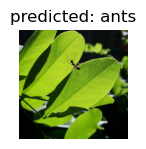

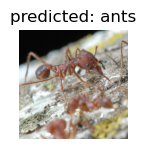

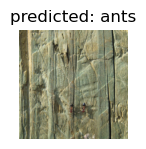

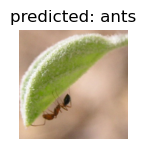

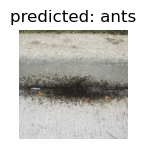

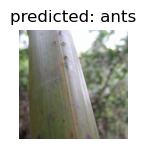

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

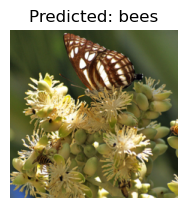

In [17]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()